In [323]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

import xgboost as xgb
from nltk.corpus import stopwords

In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

#### Посмотрим на тайтлы

In [3]:
titles_train = pd.read_csv("data/title_unify_train", sep="\t", header=None, encoding='utf-8')
titles_train.columns = ["Id", "title", "count"]
titles_train1 = pd.DataFrame(titles_train.groupby("Id")['title'].apply(lambda x: x.tolist()))
titles_train1.title = titles_train1.title.apply(lambda x: " ".join(x)) ## склеили тайтлы по юзеру вместе

In [4]:
titles_train1 = titles_train1.reset_index()
titles_train1.head()

,Id,title
0,000000013CB5719C0000A2C90002C101,бесплатный надёжный почта рамблер электронный ...
1,00000001442BE24000001B7D00F50801,24-х 34-х до договор неделя новость предложить...
2,00000001448580F800003F1B31FB0901,авто бош контакт королёв сервис авто бош корол...
3,0000000145BDB2FF000157971645E901,ua втрать війни донбасі за на новини озвучить ...
4,000000014602771F0000DB9359714C01,black walnut грецкий орех чёрный inmoment ru w...


загрузим трейн по возрасту

In [5]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['Id', 'age']

####  Добавим урлы

In [6]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['Id', 'url', 'Count']

In [7]:
url_df = urls_train_df.drop("Count", axis=1).merge(age_train_df, on='Id', how='left')
url_df = url_df.sort_values(by="Id")
url_df["decade"] = url_df.age.apply(lambda x: int(np.floor((x)/10)))

В предположении, что p(url|age) имеет некоторое распределение, восстановим распределение урлов про декадам на обучающей выборке 

In [8]:
aggreg = url_df.groupby(["url", "decade"]).age.count().unstack()
aggreg = aggreg.fillna(0)
aggreg = aggreg.reset_index()
aggreg["all_cnt"] = aggreg[aggreg.columns[1:]].sum(axis=1)

In [9]:
aggreg_filt = aggreg#[aggreg.all_cnt > 2]

In [10]:
aggreg_urls_probs_filt = pd.concat([aggreg_filt.url, aggreg_filt[aggreg_filt.columns[1:-1]].div(aggreg_filt.all_cnt, axis='rows')], axis=1)

In [26]:
#url - decade probs
aggreg_urls_probs_filt.head()

,url,0,1,2,3,4,5,6,7,8,9
0,0-1.a100.nthosting.ru,0.333333,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0-1.ru,0.028409,0.011364,0.210227,0.346591,0.215909,0.136364,0.045455,0.005682,0.0,0.0
2,0-15kdm.ru,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0-3.ru,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0
4,0-360.ru,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.0,0.0


In [24]:
all_set_probs = urls_train_df.drop("Count", axis=1).merge(aggreg_urls_probs_filt, on="url").sort_values(by="Id").reset_index().drop("index", axis=1)

In [18]:
all_set_probs.head()

,Id,url,0,1,2,3,4,5,6,7,8,9
0,000000013CB5719C0000A2C90002C101,r0.ru,0.011605,0.034816,0.150870,0.311412,0.206963,0.189555,0.075435,0.013540,0.005803,0.000000
1,000000013CB5719C0000A2C90002C101,id.rambler.ru,0.014819,0.060953,0.305132,0.305351,0.182714,0.089350,0.032776,0.006351,0.001533,0.001022
2,000000013CB5719C0000A2C90002C101,mail.rambler.ru,0.019425,0.036012,0.243083,0.313185,0.216987,0.119580,0.041846,0.007576,0.001357,0.000950
3,00000001442BE24000001B7D00F50801,secretmag.ru,0.019522,0.013147,0.139442,0.285259,0.283665,0.173705,0.067331,0.014343,0.001992,0.001594
4,00000001442BE24000001B7D00F50801,govoritmoskva.ru,0.018112,0.020972,0.197331,0.249762,0.220210,0.179218,0.088656,0.017159,0.006673,0.001907


In [19]:
# аггрегация по юзерам
aggr = pd.concat([all_set_probs.groupby("Id").sum(), all_set_probs.groupby("Id").count()[0]], axis=1)

In [21]:
aggr.head(2)

,0,1,2,3,4,5,6,7,8,9,0
Id,,,,,,,,,,,
000000013CB5719C0000A2C90002C101,0.045849,0.131781,0.699085,0.929948,0.606665,0.398485,0.150057,0.027466,0.008692,0.001972,3
00000001442BE24000001B7D00F50801,0.819073,0.686682,6.875526,10.354937,9.113721,6.139414,2.482999,0.390805,0.073883,0.062959,37


In [22]:
aggr.columns = ["decade_0", "decade_1", "decade_2", "decade_3", "decade_4",
               "decade_5", "decade_6", "decade_7", "decade_8", "decade_9", "cnt"] 

In [23]:
aggr.head()

,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9,cnt
Id,,,,,,,,,,,
000000013CB5719C0000A2C90002C101,0.045849,0.131781,0.699085,0.929948,0.606665,0.398485,0.150057,0.027466,0.008692,0.001972,3
00000001442BE24000001B7D00F50801,0.819073,0.686682,6.875526,10.354937,9.113721,6.139414,2.482999,0.390805,0.073883,0.062959,37
00000001448580F800003F1B31FB0901,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
0000000145BDB2FF000157971645E901,0.145078,0.334114,2.590656,3.329806,1.974950,1.154019,0.397011,0.064615,0.003316,0.006435,10
000000014602771F0000DB9359714C01,0.113171,0.435530,3.085147,3.202767,2.284845,1.519141,0.294689,0.059143,0.004823,0.000743,11


In [29]:
# как бы вероятности, что юзер попадет в декаду, основываясь на урлах
probs_users = aggr[aggr.columns[:-1]].div(aggr[aggr.columns[-1]], axis="rows")

In [30]:
decades = [i*10+5 for i in range(10)]  # по центрам интервалов
decades

[5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

взвесим согласно вероятностям

In [31]:
pred_simple_probs_urls = probs_users.apply(lambda x: sum(x.values*decades), axis=1)

In [32]:
m = pred_simple_probs_urls.reset_index().merge(age_train_df)
m.columns = ["Id", "prob", "age"]
m.head(2)

,Id,prob,age
0,000000013CB5719C0000A2C90002C101,38.062559,53
1,00000001442BE24000001B7D00F50801,40.525900,48


In [33]:
rmse(m.prob.values, m.age.values)  ## даже такой простой подход дает неплохой результат! неплохоо

11.646980267145002

попробуем другое дробление возраста - не на декады, а по равновероятным cumsum интервалам

In [35]:
# 10 штук
interval_labels = [22, 26, 29, 31, 34, 38, 41, 46, 53]  # побъем cussum по равновероятным интервалам

In [36]:
def create_intervals(age):
    if age < 22:
        return 0
    if age >= 22 and age <= 26:
        return 1
    if age > 26 and age <= 29:
        return 2
    if age > 29 and age <= 31:
        return 3
    if age > 31 and age <= 34:
        return 4
    if age > 34 and age <= 38:
        return 5
    if age > 38 and age <= 41:
        return 6
    if age > 41 and age <= 46:
        return 7
    if age > 46 and age <= 53:
        return 8
    if age > 53:
        return 9

теперь повторим то же самое

In [37]:
url_df = urls_train_df.drop("Count", axis=1).merge(age_train_df, on='Id', how='left')
url_df = url_df.sort_values(by="Id")
url_df["decade"] = url_df.age.apply(create_intervals)

In [66]:
aggreg = url_df.groupby(["url", "decade"]).age.count().unstack()
aggreg = aggreg.fillna(0)
aggreg = aggreg.reset_index()
aggreg["all_cnt"] = aggreg[aggreg.columns[1:]].sum(axis=1)

aggreg_filt = aggreg#[aggreg.all_cnt > 2]
aggreg_urls_probs_filt = pd.concat([aggreg_filt.url, aggreg_filt[aggreg_filt.columns[1:-1]].div(aggreg_filt.all_cnt, axis='rows')], axis=1)

all_set_probs = urls_train_df.drop("Count", axis=1).merge(aggreg_urls_probs_filt, on="url").sort_values(by="Id").reset_index().drop("index", axis=1)

aggr = pd.concat([all_set_probs.groupby("Id").sum(), all_set_probs.groupby("Id").count()[0]], axis=1)
aggr.columns = ["decade_0", "decade_1", "decade_2", "decade_3", "decade_4",
               "decade_5", "decade_6", "decade_7", "decade_8", "decade_9", "cnt"] 
probs_users_tr = aggr[aggr.columns[:-1]].div(aggr[aggr.columns[-1]], axis="rows")

In [67]:
probs_users_tr.head(2)

,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9
Id,,,,,,,,,,
000000013CB5719C0000A2C90002C101,0.090940,0.091018,0.110280,0.071454,0.106768,0.095862,0.098688,0.090686,0.124294,0.120008
00000001442BE24000001B7D00F50801,0.059752,0.064204,0.102565,0.059760,0.089081,0.084155,0.106211,0.101531,0.176652,0.156089


## сразу сделаем то же для теста

In [155]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['Id', 'url', 'Count']

all_set_probs_test = urls_test_df.drop("Count", axis=1).merge(aggreg_urls_probs_filt).sort_values(by="Id").reset_index().drop("index", axis=1)

aggr_test = pd.concat([all_set_probs_test.groupby("Id").sum(), all_set_probs_test.groupby("Id").count()[0]], axis=1)
aggr_test.columns = ["decade_0", "decade_1", "decade_2", "decade_3", "decade_4",
               "decade_5", "decade_6", "decade_7", "decade_8", "decade_9", "cnt"] 
probs_users_test = aggr_test[aggr_test.columns[:-1]].div(aggr_test[aggr_test.columns[-1]], axis="rows")

## Попробуем попредсказывать

In [40]:
## intervals = [22, 26, 29, 31, 34, 38, 41, 46, 53]
decades = [11, 24, 27, 30, 33, 36, 39, 43, 50, 76]  # по центрам интервалов

#decades = [0, 15, 22, 28, 30, 36, 40, 45, 55, 77]  # не по центрам интервалов

взвесим согласно вероятностям

In [127]:
pred_simple_probs_urls = probs_users.apply(lambda x: sum(x.values*decades), axis=1)

In [128]:
m = pred_simple_probs_urls.reset_index().merge(age_train_df)
m.columns = ["Id", "prob", "age"]
m.head(2)

,Id,prob,age
0,000000013CB5719C0000A2C90002C101,38.364026,53
1,00000001442BE24000001B7D00F50801,41.932921,48


In [129]:
rmse(m.prob.values, m.age.values)  ## еще лучше!!!!

11.489914983525567

### попробуем предсказать с мл

In [130]:
probs_users_tr_age = probs_users_tr.reset_index().merge(age_train_df).set_index("Id") #add age
probs_users_tr_age.head(2)

,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9,age
Id,,,,,,,,,,,
000000013CB5719C0000A2C90002C101,0.090940,0.091018,0.110280,0.071454,0.106768,0.095862,0.098688,0.090686,0.124294,0.120008,53
00000001442BE24000001B7D00F50801,0.059752,0.064204,0.102565,0.059760,0.089081,0.084155,0.106211,0.101531,0.176652,0.156089,48


In [135]:
y = probs_users_tr_age.age
X = probs_users_tr_age.drop("age", axis=1)

In [136]:
kf = KFold(probs_users_tr_age.shape[0], n_folds=5, shuffle=True)
metric = []

for itr, ite in kf:
    

    X_train = X.iloc[itr]
    y_train = y.iloc[itr]
    X_test, y_test = X.iloc[ite], y.iloc[ite]
    
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    print rmse(y_test, pred_lr)
    metric.append(rmse(y_test, pred_lr))

np.mean(metric)

10.8611268728
10.9528300848
10.8590176242
10.9034313142
10.8432814338


10.88393746594954

### Обучимся на всем и предскажем для теста c ml

In [158]:
probs_users_test.head()

,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9
Id,,,,,,,,,,
000000014A02348E701552980349FF01,0.079265,0.087682,0.100754,0.063741,0.104640,0.088078,0.088226,0.110199,0.139706,0.137709
000000014A10EA183BF8594A0B2AB201,0.066700,0.074079,0.090038,0.067339,0.093445,0.092733,0.096282,0.116003,0.150577,0.152805
000000014A4FE5C33A929D4C26943601,0.068373,0.090632,0.077443,0.096244,0.089490,0.079064,0.090719,0.090090,0.140135,0.177810
000000014B7BB9957784A9BC0AC9F401,0.071417,0.072761,0.100378,0.065651,0.099474,0.087393,0.085334,0.231883,0.098636,0.087071
000000014C7749F896D82C2B01E8B801,0.080590,0.103677,0.105508,0.077259,0.105115,0.113410,0.094787,0.099047,0.111771,0.108837


In [156]:
##probs_users_test - ниже


lr = LinearRegression()
lr.fit(X, y)
pred_lr_test = lr.predict(probs_users_test)

In [161]:
probs_users_test1 = pd.concat([probs_users_test.reset_index().Id, pd.DataFrame(pred_lr_test, columns=["pred_age"])], axis=1)
probs_users_test1.head(2)

,Id,pred_age
0,000000014A02348E701552980349FF01,40.542236
1,000000014A10EA183BF8594A0B2AB201,43.670654


In [162]:
probs_users_test1.shape

(19974, 2)

In [163]:
sample_df = pd.read_csv('submissions/sample_submission.csv')
sample_df.shape

(19979, 2)

In [164]:
miss_idx = set(sample_df.Id.values) - set(probs_users_test.index.values)
miss_idx  ## есть 

{'00000001545483F30F717F5A0721E401',
 '00000046549F9C26429C4B0159BFEE01',
 '000000465684D839B64B58DA9701F701',
 '000022D456544DE3771122F857A6F201',
 '06210D9556EFE0E30000054678B0D901'}

In [165]:
miss_df = pd.DataFrame(zip(list(miss_idx), 30* np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']
#miss_df = miss_df.set_index("Id")
miss_df

,Id,age
0,000022D456544DE3771122F857A6F201,30.0
1,06210D9556EFE0E30000054678B0D901,30.0
2,00000046549F9C26429C4B0159BFEE01,30.0
3,00000001545483F30F717F5A0721E401,30.0
4,000000465684D839B64B58DA9701F701,30.0


In [169]:
probs_users_test1.columns = ["Id", "age"]
probs_users_test1.head()

,Id,age
0,000000014A02348E701552980349FF01,40.542236
1,000000014A10EA183BF8594A0B2AB201,43.670654
2,000000014A4FE5C33A929D4C26943601,43.424561
3,000000014B7BB9957784A9BC0AC9F401,39.563232
4,000000014C7749F896D82C2B01E8B801,37.131836


In [173]:
all_test_set = pd.merge(probs_users_test1.reset_index(), miss_df, on=["Id", "age"], how="outer").drop("index", axis=1)
all_test_set = all_test_set.sort_values(by="Id")
all_test_set.shape

(19979, 2)

In [174]:
all_test_set.to_csv("submissions/linreg_prob_urls_another_decades.csv", index=False)

### предскажем для теста  без ml (по распределению только)

In [175]:
decades = [11, 24, 27, 30, 33, 36, 39, 43, 50, 76]  # по центрам интервалов
#decades = [0, 15, 22, 28, 30, 36, 40, 45, 55, 77] # не по центрам интервалов
pred_simple_probs_test = probs_users_test.apply(lambda x: sum(x.values*decades), axis=1)

In [176]:
pred_simple_probs_test.head(2)

Id
000000014A02348E701552980349FF01    39.863371
000000014A10EA183BF8594A0B2AB201    41.269974
dtype: float64

In [53]:
pred_simple_probs_test.shape

(19974,)

In [54]:
sample_df = pd.read_csv('submissions/sample_submission.csv')
sample_df.shape

(19979, 2)

In [55]:
miss_idx = set(sample_df.Id.values) - set(pred_simple_probs_test.index.values)
miss_idx  ## есть 

{'00000001545483F30F717F5A0721E401',
 '00000046549F9C26429C4B0159BFEE01',
 '000000465684D839B64B58DA9701F701',
 '000022D456544DE3771122F857A6F201',
 '06210D9556EFE0E30000054678B0D901'}

In [56]:
miss_df = pd.DataFrame(zip(list(miss_idx), 30* np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']
#miss_df = miss_df.set_index("Id")
miss_df

,Id,age
0,000022D456544DE3771122F857A6F201,30.0
1,06210D9556EFE0E30000054678B0D901,30.0
2,00000046549F9C26429C4B0159BFEE01,30.0
3,00000001545483F30F717F5A0721E401,30.0
4,000000465684D839B64B58DA9701F701,30.0


In [57]:
pred_simple_probs_test = pred_simple_probs_test.reset_index()
pred_simple_probs_test.columns = ["Id", "age"]

In [58]:
pred_simple_probs_test.head()

,Id,age
0,000000014A02348E701552980349FF01,39.863371
1,000000014A10EA183BF8594A0B2AB201,41.269974
2,000000014A4FE5C33A929D4C26943601,41.637212
3,000000014B7BB9957784A9BC0AC9F401,38.488651
4,000000014C7749F896D82C2B01E8B801,37.908634


In [59]:
all_test_set = pd.merge(pred_simple_probs_test.reset_index(), miss_df, on=["Id", "age"], how="outer").drop("index", axis=1)

In [60]:
all_test_set = all_test_set.sort_values(by="Id")
all_test_set.head()

,Id,age
0,000000014A02348E701552980349FF01,39.863371
1,000000014A10EA183BF8594A0B2AB201,41.269974
2,000000014A4FE5C33A929D4C26943601,41.637212
3,000000014B7BB9957784A9BC0AC9F401,38.488651
4,000000014C7749F896D82C2B01E8B801,37.908634


In [522]:
all_test_set.shape

(19979, 2)

In [523]:
all_test_set.to_csv("simple_prob_urls_another_decades.csv", index=False)

In [540]:
eee = pd.DataFrame(pd.concat([all_test_set.Id, all_test_set.age.apply(lambda x: np.floor(x))], axis=1))
eee.columns = ["Id","age"]

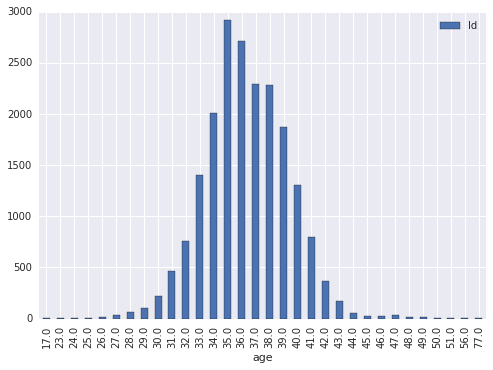

In [553]:
eee.groupby("age").count().reset_index().sort_values(by="age").set_index("age").plot(kind="bar")

### Продолжим преобразовывать урлы : сольем все урлы по юзеру в одну строку (с учетом каунтов), и похешируем

In [177]:
## учтем и каунты тоже
urls_train_df.url = urls_train_df.url.apply(lambda x: ".".join(x.split(".")[:-1]))
urls_train_df.url = urls_train_df.url.apply(lambda x: x+" ")
urls_train_df.url = urls_train_df.url.multiply(urls_train_df.Count)
urls_train_df.url = urls_train_df.url.apply(lambda x: x.strip())
urls_train_df.url = urls_train_df.url.apply(lambda x: ' '.join(x.split(' ')))

In [178]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('Id')['url'].apply(lambda x: x.tolist()))
urls_train_df['Id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'Id']

In [179]:
urls_train_df.urls = urls_train_df.urls.apply(lambda x: ' '.join(x))

In [180]:
urls_train_df.head()

,urls,Id
0,id.rambler mail.rambler r0,000000013CB5719C0000A2C90002C101
1,1prime autorambler chellak docs.cntd docs.cntd...,00000001442BE24000001B7D00F50801
2,bosch-korolev,00000001448580F800003F1B31FB0901
3,aptekanizkihcen colady gorod.dp i.ovkuse love....,0000000145BDB2FF000157971645E901
4,astrorok diets edaplus eshzdorovo gotovim inmo...,000000014602771F0000DB9359714C01


#### загрузим данные по возрасту

In [181]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['Id', 'age']

In [185]:
train_df_title = titles_train1.merge(age_train_df, on='Id', how='outer')
#train_df_urls = urls_train_df.merge(age_train_df, on='Id', how='left')

train_df = train_df_title.merge(urls_train_df, on='Id', how='outer')
train_df = train_df.merge(probs_users_tr.reset_index(), how="left")#

In [186]:
train_df.head(2)

,Id,title,age,urls,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9
0,000000013CB5719C0000A2C90002C101,бесплатный надёжный почта рамблер электронный ...,53,id.rambler mail.rambler r0,0.090940,0.091018,0.110280,0.071454,0.106768,0.095862,0.098688,0.090686,0.124294,0.120008
1,00000001442BE24000001B7D00F50801,24-х 34-х до договор неделя новость предложить...,48,1prime autorambler chellak docs.cntd docs.cntd...,0.059752,0.064204,0.102565,0.059760,0.089081,0.084155,0.106211,0.101531,0.176652,0.156089


In [225]:
train_df.shape

(118679, 14)

In [231]:
train_df[pd.isnull(train_df.urls)].head()

,Id,title,age,urls,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9


In [227]:
train_df.urls.fillna('', inplace=True)

In [234]:
train_df[pd.isnull(train_df.title)].head()

,Id,title,age,urls,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9


In [233]:
train_df.title.fillna('', inplace=True)

In [229]:
for col in probs_users_tr.columns:
    train_df[col].fillna(0.10, inplace=True)

In [230]:
train_df[pd.isnull(train_df.decade_0)].head()

,Id,title,age,urls,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9


### проделаем то же с тестовым сетом

In [200]:
titles_test = pd.read_csv("data/title_unify_test", sep="\t", header=None,encoding='utf-8')
titles_test.columns = ["Id", "title", "count"]
titles_test1 = pd.DataFrame(titles_test.groupby("Id")['title'].apply(lambda x: x.tolist()))
titles_test1.title = titles_test1.title.apply(lambda x: " ".join(x))

In [201]:
titles_test1 = titles_test1.reset_index()
titles_test1.head()

,Id,title
0,000000014A02348E701552980349FF01,11-й гектар дом коммунизм на набережная недост...
1,000000014A10EA183BF8594A0B2AB201,20-летний выглядеть девушка как королева наташ...
2,000000014A4FE5C33A929D4C26943601,медийный портал рамблер
3,000000014B7BB9957784A9BC0AC9F401,бесплатно код онлайн срочно статистика или инн...
4,000000014C7749F896D82C2B01E8B801,bank privat автокредитование банковский банком...


In [202]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['Id', 'url', 'Count']

In [203]:
urls_test_df.url = urls_test_df.url.apply(lambda x: ".".join(x.split(".")[:-1]))
urls_test_df.url = urls_test_df.url.apply(lambda x: x+" ")
urls_test_df.url = urls_test_df.url.multiply(urls_test_df.Count)
urls_test_df.url = urls_test_df.url.apply(lambda x: x.strip())
urls_test_df.url = urls_test_df.url.apply(lambda x: ' '.join(x.split(' ')))

In [204]:
urls_test_df = pd.DataFrame(urls_test_df.groupby('Id')['url'].apply(lambda x: x.tolist()))
urls_test_df['Id'] = urls_test_df.index
urls_test_df.index = range(len(urls_test_df))
urls_test_df.columns = ['urls', 'Id']

In [205]:
urls_test_df.urls = urls_test_df.urls.apply(lambda x: ' '.join(x))

In [206]:
urls_test_df.head()

,urls,Id
0,1000bankov 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv 4pu...,000000014A02348E701552980349FF01
1,autorambler bilettorg dsol-druzhba family.ramb...,000000014A10EA183BF8594A0B2AB201
2,photosight photosight photosight photosight ph...,000000014A4FE5C33A929D4C26943601
3,base.consultant dogovor-obrazets fd mail.rambl...,000000014B7BB9957784A9BC0AC9F401
4,assessor assessor audit-it base.garant compsam...,000000014C7749F896D82C2B01E8B801


In [210]:
test_df = titles_test1.merge(urls_test_df, on='Id', how='outer')
test_df = test_df.merge(probs_users_test.reset_index(), how="left")
test_df.head(2)

,Id,title,urls,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9
0,000000014A02348E701552980349FF01,11-й гектар дом коммунизм на набережная недост...,1000bankov 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv 4pu...,0.079265,0.087682,0.100754,0.063741,0.104640,0.088078,0.088226,0.110199,0.139706,0.137709
1,000000014A10EA183BF8594A0B2AB201,20-летний выглядеть девушка как королева наташ...,autorambler bilettorg dsol-druzhba family.ramb...,0.066700,0.074079,0.090038,0.067339,0.093445,0.092733,0.096282,0.116003,0.150577,0.152805


In [211]:
test_df.merge(aggreg, how="left")

(19979, 13)

In [213]:
test_df[pd.isnull(test_df.title)].head(1)

,Id,title,urls,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9
19960,00000046546F3F721C92663B86D4EE01,NaN,mail.rambler mail.rambler mail.rambler mail.ra...,0.086937,0.096186,0.115396,0.077315,0.107199,0.097803,0.090115,0.102348,0.120179,0.106521


In [214]:
test_df.title.fillna('', inplace=True)

In [219]:
test_df[pd.isnull(test_df.urls)].head(1)

,Id,title,urls,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9


In [217]:
test_df.urls.fillna('', inplace=True)

In [218]:
for col in probs_users_tr.columns:
    test_df[col].fillna(0.10, inplace=True)

ну ок, вс еслили в один сет

### погнали обучаться

In [276]:
# выделим декады
X_decades = train_df[probs_users_tr.columns]
X_decades_test = test_df[probs_users_tr.columns]

In [220]:
stops = stopwords.words('russian') + stopwords.words('english')

In [221]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(n_features=2000, stop_words=stops, non_negative=True)
hv.fit(train_df.title[train_df.title != ""].append(test_df.title[test_df.title != ""]))

HashingVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.float64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, n_features=2000, ngram_range=(1, 1),
         non_negative=True, norm=u'l2', preprocessor=None,
         stop_words=[u'\u0438', u'\u0432', u'\u0432\u043e', u'\u043d\u0435', u'\u0447\u0442\u043e', u'\u043e\u043d', u'\u043d\u0430', u'\u044f', u'\u0441', u'\u0441\u043e', u'\u043a\u0430\u043a', u'\u0430', u'\u0442\u043e', u'\u0432\u0441\u0435', u'\u043e\u043d\u0430', u'\u0442\u0430\u043a', u'\u0435\u0433\u...n', u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren', u'won', u'wouldn'],
         strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
         tokenizer=None)

похешируем тайтлы

In [235]:
%%time
X_titles = hv.transform(train_df.title)
X_titles = X_titles.todense()
y = train_df.age

CPU times: user 1min 27s, sys: 791 ms, total: 1min 28s
Wall time: 1min 28s


In [236]:
%%time
X_titles_test = hv.transform(test_df.title)
X_titles_test = X_titles_test.todense()

CPU times: user 35 s, sys: 225 ms, total: 35.2 s
Wall time: 35.1 s


### nmf on titles data

In [ ]:
%%time
transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf_title1 = transformer.fit_transform(X_titles)
X_nmf_title_test1 = transformer.fit_transform(X_titles_test)

In [ ]:
%%time
transformer = sklearn.decomposition.NMF(n_components=200)
X_nmf_title2 = transformer.fit_transform(X_titles)
X_nmf_title_test2 = transformer.fit_transform(X_titles_test)

### теперь урлы

In [237]:
X_all_urls = train_df.urls[train_df.urls!=""].append(test_df.urls[test_df.urls!=""])

In [238]:
%%time
hw = HashingVectorizer(n_features=1000, non_negative=True).fit(X_all_urls.values)
X_urls = hw.transform(train_df.urls.values).todense()

CPU times: user 13 s, sys: 253 ms, total: 13.3 s
Wall time: 13.3 s


In [239]:
X_urls_test = hw.transform(test_df.urls.values).todense()

### nmf on urls

In [ ]:
%%time
transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf_urls1 = transformer.fit_transform(X_urls)
X_nmf_urls_test1 = transformer.fit_transform(X_urls_test)

In [ ]:
%%time
transformer = sklearn.decomposition.NMF(n_components=200)
X_nmf_urls2 = transformer.fit_transform(X_urls)
X_nmf_urls_test2 = transformer.fit_transform(X_urls_test)

## holdout

In [242]:
itrain, ite = cross_validation.train_test_split(range(train_df.shape[0]), test_size=0.3, random_state=23)
len(itrain), len(ite)

(83075, 35604)

linreg on data_titles

In [243]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_titles[itrain, :], y[itrain])

pred_X_titles = reg.predict(X_titles[ite, :])

CPU times: user 3min 29s, sys: 4min 35s, total: 8min 5s
Wall time: 49.6 s


In [244]:
print rmse(y[ite], pred_X_titles)

11.8647960792


Линейная модель на NMF_100 от titles

In [109]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_title1[itrain, :], y[itrain])

pred_X_nmf_title1 = reg.predict(X_nmf_title1[ite, :])

CPU times: user 8.41 s, sys: 5.36 s, total: 13.8 s
Wall time: 1.01 s


In [110]:
print rmse(y[ite], pred_X_nmf_title1)

11.9731456527


Линейная модель на NMF_200 от titles

In [111]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_title2[itrain, :], y[itrain])

pred_X_nmf_title2 = reg.predict(X_nmf_title2[ite, :])

CPU times: user 12 s, sys: 15 s, total: 27 s
Wall time: 1.93 s


In [112]:
print rmse(y[ite], pred_X_nmf_title2)

11.9276659258


linreg on data_urls

In [245]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_urls[itrain, :], y[itrain])

pred_X_urls = reg.predict(X_urls[ite, :])

CPU times: user 1min, sys: 1min 59s, total: 3min
Wall time: 15.6 s


In [246]:
print rmse(y[ite], pred_X_urls)

11.8744189331


Линейная модель на NMF_100 от urls

In [168]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_urls1[itrain, :], y[itrain])

pred_X_nmf_urls1 = reg.predict(X_nmf_urls1[ite, :])
print rmse(y[ite], pred_X_nmf_urls1)

11.9395690478
CPU times: user 12.8 s, sys: 10.3 s, total: 23.1 s
Wall time: 1.91 s


Линейная модель на NMF_200 от urls

In [116]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_urls2[itrain, :], y[itrain])

pred_X_nmf_urls2 = reg.predict(X_nmf_urls2[ite, :])
print rmse(y[ite], pred_X_nmf_urls2)

11.8932235612
CPU times: user 12 s, sys: 17.4 s, total: 29.4 s
Wall time: 2.09 s


linreg on all data

In [117]:
%%time

X = np.hstack([X_urls, X_titles, X_nmf_title1, X_nmf_urls1, X_nmf_title2, X_nmf_urls2])
reg = LinearRegression(n_jobs=-1)
reg.fit(X[itrain, :], y[itrain])

CPU times: user 13min 37s, sys: 9min 54s, total: 23min 31s
Wall time: 2min 32s


In [118]:
pred_X = reg.predict(X[ite, :])
print rmse(y[ite], pred_X)

11.8463762633


linreg on decades

In [254]:
#%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_decades.loc[itrain], y[itrain])
pred_X_decades = reg.predict(X_decades.loc[ite])
print rmse(y[ite], pred_X_decades)

10.8664144157


## create weighted average with heamy

In [266]:
%%time
kf = KFold(probs_users_tr_age.shape[0], n_folds=3, shuffle=True)


for itr, ite in kf:
    print '--'
    dataset_titles = Dataset(X_titles[itr, :], y[itr], X_titles[ite, :])
    dataset_urls = Dataset(X_urls[itr, :], y[itr], X_urls[ite, :]) 
    dataset_decades = Dataset(X_decades.loc[itr], y[itr], X_decades.loc[ite])

    lr_titles = Regressor(dataset=dataset_titles, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':1},
                         name='lr_titles')

    lr_urls = Regressor(dataset=dataset_urls, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':1},
                         name='lr_urls')

    lr_decades = Regressor(dataset=dataset_decades, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':1},
                         name='lr_decades')

    pipeline = ModelsPipeline(lr_titles, lr_urls, lr_decades)

    weights = pipeline.find_weights(rmse)
    result = pipeline.weight(weights)

--
Best Score (rmse): 10.8971193391
Best Weights: [  4.48008334e-02   5.42101086e-18   9.55199167e-01]
--
Best Score (rmse): 10.8175549185
Best Weights: [  5.91643194e-02   2.46113893e-17   9.40835681e-01]
--
Best Score (rmse): 10.8785347856
Best Weights: [ 0.07197029  0.          0.92802971]
CPU times: user 10min 35s, sys: 19min 58s, total: 30min 34s
Wall time: 4min 4s


In [270]:
(np.array([4.48008334e-02,   5.42101086e-18,   9.55199167e-01]) +\
np.array([ 5.91643194e-02, 2.46113893e-17, 9.40835681e-01]) +\
np.array([ 0.07197029, 0, 0.92802971]))/3

array([  5.86451476e-02,   1.00108001e-17,   9.41354853e-01])

In [273]:
## итого
w1 = 0.0586451476
w3 = 1 - w1

## обучимся на всех данных и замешаем

In [292]:
%%time

dataset_titles = Dataset(X_titles, y, X_titles_test)
dataset_decades = Dataset(X_decades, y, X_decades_test)

lr_titles = Regressor(dataset=dataset_titles, 
                      estimator=LinearRegression,
                      parameters={'normalize': True, 'n_jobs':1},
                      name='lr_titles')

lr_decades = Regressor(dataset=dataset_decades, 
                       estimator=LinearRegression,
                       parameters={'normalize': True, 'n_jobs':1},
                       name='lr_decades')

pipeline = ModelsPipeline(lr_titles, lr_decades)

weights = pipeline.find_weights(rmse)
result = pipeline.weight(weights)

Best Score (rmse): 10.9122623026
Best Weights: [ 0.08454537  0.91545463]
CPU times: user 3min 35s, sys: 4min 44s, total: 8min 20s
Wall time: 1min 2s


In [293]:
%%time
predicted_age_weights = result.execute()

In [298]:
predicted_age_weights

array([ 40.29843852,  43.53451344,  42.63543716, ...,  36.40536393,
        36.40536393,  38.60638864])

In [306]:
subm = pd.concat([test_df.Id, pd.DataFrame(predicted_age_weights, columns=["age"])], axis=1)

In [307]:
subm.shape

(19979, 2)

In [309]:
subm.sort_values(by="Id").to_csv("submissions/weighted_sum_of_linreg_on_decades_and_titles.csv", index=False)

### потестим стекинг на 3 модельках (линрег - модель верхнего уровня)

In [313]:
%%time

itrain, itest = cross_validation.train_test_split(range(train_df.shape[0]), test_size=0.3, random_state=23)
len(itrain), len(itest)

dataset_titles = Dataset(X_titles[itrain, :], y[itrain], X_titles[itest, :])
dataset_urls = Dataset(X_urls[itrain, :], y[itrain], X_urls[itest, :]) 
dataset_decades = Dataset(X_decades.loc[itrain], y[itrain], X_decades.loc[itest])

lr_titles = Regressor(dataset=dataset_titles, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_titles')

lr_urls = Regressor(dataset=dataset_urls, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_urls')

lr_decades = Regressor(dataset=dataset_decades, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_decades')

pipeline = ModelsPipeline(lr_titles, lr_urls, lr_decades)
stack_ds_all = pipeline.stack(k=5,seed=42)

stacker = Regressor(dataset=stack_ds_all, estimator=LinearRegression)
results = stacker.predict()

KeyboardInterrupt: 

In [311]:
results = stacker.validate(k=5,scorer=rmse)

Metric: rmse
Folds accuracy: [10.868267585747121, 10.870369378559994, 10.910566979951982, 10.75014227305917, 10.743209369156386]
Mean accuracy: 10.8285111173
Standard Deviation: 0.0685330860222
Variance: 0.00469678387973


#### на все

In [314]:
%%time

dataset_titles = Dataset(X_titles, y, X_titles_test)
dataset_urls = Dataset(X_urls, y, X_urls_test) 
dataset_decades = Dataset(X_decades, y, X_decades_test)

lr_titles = Regressor(dataset=dataset_titles, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_titles')

lr_urls = Regressor(dataset=dataset_urls, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_urls')

lr_decades = Regressor(dataset=dataset_decades, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_decades')

pipeline = ModelsPipeline(lr_titles, lr_urls, lr_decades)
stack_ds_all = pipeline.stack(k=5,seed=42)

stacker = Regressor(dataset=stack_ds_all, estimator=LinearRegression)
results = stacker.predict()

CPU times: user 32min 7s, sys: 45min 55s, total: 1h 18min 3s
Wall time: 8min 38s


In [315]:
results

array([ 40.30330629,  43.90632332,  42.27028246, ...,  36.17187604,
        36.17187604,  38.4864321 ])

In [318]:
subm = pd.concat([test_df.Id, pd.DataFrame(results, columns=["age"])], axis=1)
subm.sort_values(by="Id").to_csv("submissions/stacking_5_folds_linreg_on_decades_urls_titles.csv", index=False)

## на public lb - 11.96782

### потюним доп. модели

In [640]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(n_estimators=250, max_depth=None, #min_samples_leaf=10, 
                         #max_features = 2*X_nmf_title1.shape[1]/3,
                         bootstrap=True, n_jobs=-1, 
                         random_state=42, verbose=0)

CPU times: user 2 ms, sys: 89 ms, total: 91 ms
Wall time: 91.3 ms


In [639]:
kf = KFold(X_decades.shape[0], n_folds=3, shuffle=True)
m = []

for itr, ite in kf:
    et.fit(X_decades.loc[itr, :], y[itr])
    print rmse(y[ite], et.predict(X_decades.loc[ite, :]))
    m.append(rmse(y[ite], et.predict(X_decades.loc[ite, :])))
    
print 'mean_rmse:', np.mean(m)

9.91286896925
9.87851260477
9.96117235473
mean_rmse: 9.91751797625


In [642]:
et.fit(X_decades.loc[itr, :], y[itr])
pr = et.predict(X_decades.loc[ite, :])

In [ ]:
9.8839575169
9.95941855468
9.93869270986

In [590]:
%%time
from sklearn import pipeline as sklearn_pipe
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import Ridge

"""pipe = sklearn_pipe.Pipeline([('tfidf', TfidfTransformer(use_idf=False)), 
                              ('linear_model', Ridge(alpha=10.0))])"""

pipe = sklearn_pipe.Pipeline([('tfidf', TfidfTransformer(use_idf=False)), 
                              ('linear_model', Ridge(alpha=17.0))])

pipe.fit(X_urls[itr, :], y[itr])
print rmse(y[ite], pipe.predict(X_urls[ite, :]))

11.8443113499
CPU times: user 3.1 s, sys: 192 ms, total: 3.29 s
Wall time: 3.29 s


In [612]:
linreg = Ridge()#alpha=8.5)
linreg = LinearRegression(n_jobs=-1)

linreg.fit(X_nmf_title1[itr, :], y[itr])
print rmse(y[ite], linreg.predict(X_nmf_title1[ite, :]))

12.0239086527


In [ ]:
12.0040625154 - default linreg
 - default ridge
 - ridge(alpha=10)


#### xgboost

In [750]:
param = {}
param['max_depth'] = 3
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.01
param['subsample'] = 0.6
param['colsample_bytree'] = 0.9
param['colsample_bylevel'] = 0.7
#param['min_child_weight'] = 1
param['gamma'] = 0.1
#param['reg_alpha'] = 1e-05
#param['scale_pos_weight'] = 1

numround = 1000

In [751]:
X_all_datatrain = xgb.DMatrix(X_nmf_urls1, label = y)

In [752]:
xgb.cv(param, X_all_datatrain, num_boost_round=10000, nfold=3, metrics="rmse", \
       verbose_eval=10, as_pandas=False, seed=27)

[0]	train-rmse:37.3678+0.0242114	test-rmse:37.3679+0.0493091
[10]	train-rmse:34.1916+0.0229266	test-rmse:34.192+0.0487816
[20]	train-rmse:31.3561+0.0216284	test-rmse:31.3571+0.0485764
[30]	train-rmse:28.8277+0.0210559	test-rmse:28.8295+0.0479745
[40]	train-rmse:26.5793+0.0202274	test-rmse:26.582+0.0479186
[50]	train-rmse:24.5876+0.0196588	test-rmse:24.5909+0.0475591
[60]	train-rmse:22.8297+0.0179168	test-rmse:22.8339+0.0485553
[70]	train-rmse:21.2815+0.0173959	test-rmse:21.2868+0.0484201
[80]	train-rmse:19.9252+0.0174356	test-rmse:19.9316+0.0478473
[90]	train-rmse:18.7423+0.0171509	test-rmse:18.7498+0.0477047
[100]	train-rmse:17.7147+0.0173391	test-rmse:17.7235+0.0472272
[110]	train-rmse:16.8258+0.0177079	test-rmse:16.8359+0.0462626
[120]	train-rmse:16.0614+0.0176833	test-rmse:16.073+0.0459678
[130]	train-rmse:15.4064+0.0171898	test-rmse:15.4193+0.0461104
[140]	train-rmse:14.8485+0.0175369	test-rmse:14.8631+0.0456153
[150]	train-rmse:14.3742+0.017351	test-rmse:14.3902+0.045557
[160]	tr

KeyboardInterrupt: 

#### lightgbm

In [768]:
import os
from pylightgbm.models import GBMRegressor
os.environ['LIGHTGBM_EXEC'] = "/usr/local/bin/lightgbm"

In [793]:
light = GBMRegressor(
    num_threads=-1,
    learning_rate = 0.01,
    num_iterations = 5000, 
    verbose = True, 
    early_stopping_round = 100,
    feature_fraction = 0.67,
    bagging_fraction = 0.6,
) 

In [794]:
itrain, itest = cross_validation.train_test_split(range(train_df.shape[0]), test_size=0.3, random_state=23)
len(itrain), len(itest)

(83075, 35604)

In [796]:
%%time 

light.fit(
          X_decades.loc[itrain], 
          y[itrain], 
          test_data = [(
              X_decades.loc[itest], 
              y[itest], 
                      )]
        )

[LightGBM] [Info] Finished loading parameters
[LightGBM] [Info] Finished loading data in 0.254464 seconds
[LightGBM] [Info] Number of data: 83075, number of features: 10
[LightGBM] [Info] Finished initializing training
[LightGBM] [Info] Started training...
[LightGBM] [Info] Iteration: 1, /tmp/tmp_pHB_2/X0_test.csv : l2 loss : 37.887092
[LightGBM] [Info] 1.636491 seconds elapsed, finished iteration 1
[LightGBM] [Info] Iteration: 2, /tmp/tmp_pHB_2/X0_test.csv : l2 loss : 37.542042
[LightGBM] [Info] 1.646675 seconds elapsed, finished iteration 2
[LightGBM] [Info] Iteration: 3, /tmp/tmp_pHB_2/X0_test.csv : l2 loss : 37.195870
[LightGBM] [Info] 1.656422 seconds elapsed, finished iteration 3
[LightGBM] [Info] Iteration: 4, /tmp/tmp_pHB_2/X0_test.csv : l2 loss : 36.852671
[LightGBM] [Info] 1.690282 seconds elapsed, finished iteration 4
[LightGBM] [Info] Iteration: 5, /tmp/tmp_pHB_2/X0_test.csv : l2 loss : 36.516297
[LightGBM] [Info] 1.700023 seconds elapsed, finished iteration 5
[LightGBM] [I

### стакнем

In [664]:
#%%time  # IOError ?? 

itrain, itest = cross_validation.train_test_split(range(train_df.shape[0]), test_size=0.3, random_state=23)
len(itrain), len(itest)


dataset_titles = Dataset(X_titles[itrain, :], y[itrain], X_titles[itest, :])
dataset_titles_nmf1 = Dataset(X_nmf_title1[itrain, :], y[itrain], X_nmf_title1[itest, :])
dataset_titles_nmf2 = Dataset(X_nmf_title2[itrain, :], y[itrain], X_nmf_title2[itest, :])

dataset_urls = Dataset(X_urls[itrain, :], y[itrain], X_urls[itest, :]) 
dataset_urls_nmf1 = Dataset(X_nmf_urls1[itrain, :], y[itrain], X_nmf_urls1[itest, :])
dataset_urls_nmf2 = Dataset(X_nmf_urls2[itrain, :], y[itrain], X_nmf_urls2[itest, :]) 

dataset_decades = Dataset(X_decades.loc[itrain], y[itrain], X_decades.loc[itest])

##########################  TITLES ############################
## ---- ридж на nmf100 от заголовков
lr_titles = Regressor(dataset=dataset_titles_nmf1, 
                      estimator=LinearRegression,
                      parameters={'n_jobs': -1},
                      name='lr_titles')


# ридж на TFIDF от заголовков
def tfidf_lr1_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = sklearn_pipe.Pipeline([('tfidf', TfidfTransformer(use_idf=False)), 
                              ('linear_model', Ridge(alpha=10.0))])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr1 = Regressor(dataset=dataset_titles,
                     estimator=tfidf_lr1_,
                     name='tfidf_lr1')

rf1 = Regressor(dataset=dataset_titles_nmf1, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf1')


########################## URLS ###########################
## ----- ridge на урлах 
lr_urls = Regressor(dataset=dataset_urls, 
                     estimator=Ridge,
                     parameters={'alpha': 8.5},
                     name='lr_urls')

## ----- ridge на nmf от урлов 
lr_urls2 = Regressor(dataset=dataset_urls_nmf1, 
                     estimator=LinearRegression,
                     parameters={'n_jobs': -1},
                     name='lr_urls2')

rf2 = Regressor(dataset=dataset_urls_nmf1, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf2')

"""# ридж на TFIDF от урлов
def tfidf_lr2_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = sklearn_pipe.Pipeline([('tfidf', TfidfTransformer()), 
                                  ('linear_model', Ridge(alpha=17.0))])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr2 = Regressor(dataset=dataset_urls,
                     estimator=tfidf_lr2_,
                     name='tfidf_lr2')
"""
#################### DECADES ###############################
## ----- linreg на декадах
lr_decades = Regressor(dataset=dataset_decades, 
                         estimator=Ridge,
                         name='lr_decades')

rf3 = Regressor(dataset=dataset_decades, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf3')



pipeline = ModelsPipeline(lr_titles, tfidf_lr1, rf1, lr_urls, lr_urls2, rf2, rf3, lr_decades)
stack_ds_all = pipeline.stack(k=5,seed=42)

## correction
bad_idx_dec_train = stack_ds_all.X_train[stack_ds_all.X_train.lr_decades < 0].index  # индексы, где по декадам накосячило
bad_idx_dec_test = stack_ds_all.X_test[stack_ds_all.X_test.lr_decades < 0].index

stack_ds_all.X_train.loc[bad_idx_dec_train, "lr_decades"] = stack_ds_all.X_train\
.loc[bad_idx_dec_train, stack_ds_all.X_train.columns[:-1]].apply(lambda x: x.mean(), axis=1)

stack_ds_all.X_test.loc[bad_idx_dec_test, "lr_decades"] = stack_ds_all.X_test\
.loc[bad_idx_dec_test, stack_ds_all.X_test.columns[:-1]].apply(lambda x: x.mean(), axis=1)
##

stacker = Regressor(dataset=stack_ds_all, estimator=LinearRegression)
results = stacker.predict()

In [665]:
stacker.validate(k=5,scorer=rmse)

Metric: rmse
Folds accuracy: [9.9433404590431422, 10.003428375495876, 9.8186974989934015, 9.8815069766079571, 9.925495284263425]
Mean accuracy: 9.91449371888
Standard Deviation: 0.0618507605719
Variance: 0.00382551658332


([array([39, 31, 27, ..., 24, 28, 41]),
  array([60, 27, 37, ..., 49, 30, 39]),
  array([ 1, 32, 32, ..., 20, 66, 22]),
  array([41, 32, 29, ..., 39, 32, 32]),
  array([38, 48, 55, ..., 31, 42, 28])],
 [array([ 40.05663328,  35.49049841,  30.08365669, ...,  35.90413049,
          34.61005785,  39.10467909]),
  array([ 60.45903621,  29.17301558,  33.1762791 , ...,  41.27889553,
          42.71947728,  39.46767143]),
  array([ 38.67657421,  33.12138803,  33.26558012, ...,  31.65586764,
          51.74476805,  32.79799471]),
  array([ 32.09954226,  43.80784631,  36.75029411, ...,  36.08710617,
          33.32310046,  32.1980673 ]),
  array([ 33.3575562 ,  49.2462991 ,  40.08182526, ...,  30.65607484,
          42.25459006,  24.85831274])])

In [ ]:
10.8754569378

## на все

In [ ]:
#%%time

dataset_titles = Dataset(X_titles, y, X_titles_test)
dataset_titles_nmf1 = Dataset(X_nmf_title1, y, X_nmf_title_test1)
dataset_titles_nmf2 = Dataset(X_nmf_title2, y, X_nmf_title_test2)

dataset_urls = Dataset(X_urls, y, X_urls_test) 
dataset_urls_nmf1 = Dataset(X_nmf_urls1, y, X_nmf_urls_test1)
dataset_urls_nmf2 = Dataset(X_nmf_urls2, y, X_nmf_urls_test2)

dataset_decades = Dataset(X_decades, y, X_decades_test)

##########################  TITLES ############################
## ---- ридж на nmf100 от заголовков
lr_titles = Regressor(dataset=dataset_titles_nmf1, 
                      estimator=LinearRegression,
                      parameters={'n_jobs': -1},
                      name='lr_titles')

lr_titles2 = Regressor(dataset=dataset_titles_nmf2, 
                       estimator=LinearRegression,
                       parameters={'n_jobs': -1},
                       name='lr_titles2')


# ридж на TFIDF от заголовков
def tfidf_lr1_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = sklearn_pipe.Pipeline([('tfidf', TfidfTransformer(use_idf=False)), 
                              ('linear_model', Ridge(alpha=10.0))])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr1 = Regressor(dataset=dataset_titles,
                     estimator=tfidf_lr1_,
                     name='tfidf_lr1')

rf1 = Regressor(dataset=dataset_titles_nmf1, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf1')

rf2 = Regressor(dataset=dataset_titles_nmf2, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf2')


xgb_regr1 = Regressor(dataset=dataset_titles_nmf1, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr1')

xgb_regr2 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr2')

########################## URLS ###########################
## ----- ridge на урлах 
lr_urls = Regressor(dataset=dataset_urls, 
                     estimator=Ridge,
                     parameters={'alpha': 8.5},
                     name='lr_urls')

## ----- linreg на nmf от урлов 
lr_urls2 = Regressor(dataset=dataset_urls_nmf1, 
                     estimator=LinearRegression,
                     parameters={'n_jobs': -1},
                     name='lr_urls2')

lr_urls3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=LinearRegression,
                     parameters={'n_jobs': -1},
                     name='lr_urls3')

rf3 = Regressor(dataset=dataset_urls_nmf1, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf3')

rf4 = Regressor(dataset=dataset_urls_nmf2, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf4')


xgb_regr3 = Regressor(dataset=dataset_titles_nmf1, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr3')

xgb_regr4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr4')

# ридж на TFIDF от урлов
def tfidf_lr2_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = sklearn_pipe.Pipeline([('tfidf', TfidfTransformer()), 
                                  ('linear_model', Ridge(alpha=17.0))])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr2 = Regressor(dataset=dataset_urls,
                     estimator=tfidf_lr2_,
                     name='tfidf_lr2')

#################### DECADES ###############################
## ----- linreg на декадах
lr_decades = Regressor(dataset=dataset_decades, 
                         estimator=Ridge,
                         name='lr_decades')

rf5 = Regressor(dataset=dataset_decades, 
                estimator=ensemble.ExtraTreesRegressor,
                parameters={'n_estimators': 250, 'n_jobs': -1, 'max_depth': None, 
                            'bootstrap': True, 'min_samples_leaf': 10},
                name='rf5')

xgb_regr5 = Regressor(dataset=dataset_decades, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 3000, 'max_depth':5, 'learning_rate': 0.01,
                                 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr5')

pipeline = ModelsPipeline(lr_titles, lr_titles2, tfidf_lr1, rf1, rf2, xgb_regr1, xgb_regr2,
                          lr_urls, lr_urls2, lr_urls3, tfidf_lr2, rf3, rf4, xgb_regr3, xgb_regr4,
                          rf5, xgb_regr5, lr_decades)
stack_ds_all = pipeline.stack(k=5,seed=42)

## correction
bad_idx_dec_train = stack_ds_all.X_train[stack_ds_all.X_train.lr_decades < 0].index  # индексы, где по декадам накосячило
bad_idx_dec_test = stack_ds_all.X_test[stack_ds_all.X_test.lr_decades < 0].index

stack_ds_all.X_train.loc[bad_idx_dec_train, "lr_decades"] = stack_ds_all.X_train\
.loc[bad_idx_dec_train, stack_ds_all.X_train.columns[:-1]].apply(lambda x: x.mean(), axis=1)

stack_ds_all.X_test.loc[bad_idx_dec_test, "lr_decades"] = stack_ds_all.X_test\
.loc[bad_idx_dec_test, stack_ds_all.X_test.columns[:-1]].apply(lambda x: x.mean(), axis=1)
##

stacker = Regressor(dataset=stack_ds_all, estimator=LinearRegression)
results_all = stacker.predict()

### добавим lightgbm

In [ ]:
#%%time

dataset_titles = Dataset(X_titles, y, X_titles_test)
dataset_titles_nmf1 = Dataset(X_nmf_title1, y, X_nmf_title_test1)
dataset_titles_nmf2 = Dataset(X_nmf_title2, y, X_nmf_title_test2)

dataset_urls = Dataset(X_urls, y, X_urls_test) 
dataset_urls_nmf1 = Dataset(X_nmf_urls1, y, X_nmf_urls_test1)
dataset_urls_nmf2 = Dataset(X_nmf_urls2, y, X_nmf_urls_test2)

dataset_decades = Dataset(X_decades, y, X_decades_test)

##########################  TITLES ############################

light1 = Regressor(dataset=dataset_titles_nmf1, 
                     estimator=GBMRegressor,
                     parameters={'num_iterations': 1100, 'learning_rate': 0.01, 'feature_fraction': 0.67, 
                                 'bagging_fraction': 0.6, 'early_stopping_round':100, 'num_threads': -1},
                     name='light1')

light2 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=GBMRegressor,
                     parameters={'num_iterations': 1600, 'learning_rate': 0.01, 'feature_fraction': 0.67, 
                                 'bagging_fraction': 0.6, 'early_stopping_round':100, 'num_threads': -1},
                     name='light2')

########################## URLS ###########################
light3 = Regressor(dataset=dataset_urls_nmf1, 
                     estimator=GBMRegressor,
                     parameters={'num_iterations': 1100, 'learning_rate': 0.01, 'feature_fraction': 0.67, 
                                 'bagging_fraction': 0.6, 'early_stopping_round':100, 'num_threads': -1},
                     name='light3')

light4 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=GBMRegressor,
                     parameters={'num_iterations': 1100, 'learning_rate': 0.01, 'feature_fraction': 0.67, 
                                 'bagging_fraction': 0.6, 'early_stopping_round':100, 'num_threads': -1},
                     name='light4')

#################### DECADES ###############################


light5 = Regressor(dataset=dataset_decades, 
                     estimator=GBMRegressor,
                     parameters={'num_iterations': 900, 'learning_rate': 0.01, 'feature_fraction': 0.67, 
                                 'bagging_fraction': 0.6, 'early_stopping_round':100, 'num_threads': -1},
                     name='light5')

pipeline = ModelsPipeline(light1, light2, light3, light4, light5 )

stack_ds_light = pipeline.stack(k=5,seed=42)

[LightGBM] [Info] Finished loading parameters
[LightGBM] [Info] Finished loading data in 1.266370 seconds
[LightGBM] [Info] Number of data: 94943, number of features: 100
[LightGBM] [Info] Finished initializing training
[LightGBM] [Info] Started training...
[LightGBM] [Info] 0.407870 seconds elapsed, finished iteration 1
[LightGBM] [Info] 0.435198 seconds elapsed, finished iteration 2
[LightGBM] [Info] 0.463265 seconds elapsed, finished iteration 3
[LightGBM] [Info] 0.487727 seconds elapsed, finished iteration 4
[LightGBM] [Info] 1.243864 seconds elapsed, finished iteration 5
[LightGBM] [Info] 1.394409 seconds elapsed, finished iteration 6
[LightGBM] [Info] 1.419850 seconds elapsed, finished iteration 7
[LightGBM] [Info] 2.777535 seconds elapsed, finished iteration 8
[LightGBM] [Info] 2.817882 seconds elapsed, finished iteration 9
[LightGBM] [Info] 2.842928 seconds elapsed, finished iteration 10
[LightGBM] [Info] 2.869339 seconds elapsed, finished iteration 11
[LightGBM] [Info] 3.40776

In [699]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(n_estimators=250, max_depth=None, #min_samples_leaf=10, 
                         #max_features = 2*X_nmf_title1.shape[1]/3,
                         bootstrap=True, n_jobs=-1, 
                         random_state=42, verbose=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 78 µs


In [704]:
kf = KFold(stack_ds_all.X_train.shape[0], n_folds=3, shuffle=True)
m = []

for itr, ite in kf:
    et.fit(pd.DataFrame(stack_ds_all.X_train).loc[itr], pd.DataFrame(stack_ds_all.y_train).loc[itr])
    preds = et.predict(stack_ds_all.X_train.loc[ite])
    print rmse(stack_ds_all.y_train[ite], preds)
    m.append(rmse(y[ite], preds))
    
print 'mean_rmse:', np.mean(m)

10.0671968697
9.88901508611
10.0013110917
mean_rmse: 9.98584101585


In [717]:
et.fit(pd.DataFrame(stack_ds_all.X_train), pd.DataFrame(stack_ds_all.y_train))
results_et = et.predict(stack_ds_all.X_test)

In [723]:
subm = pd.concat([test_df.Id, pd.DataFrame(results_et, columns=["age"])], axis=1)
subm.sort_values(by="Id").to_csv("submissions/stacking_5_folds_lr_rf_tfidf_v0.csv", index=False)

## на public lb - 12.49898

In [729]:
stack_ds.X_train.corr()

,lr_titles,tfidf_lr1,rf1,lr_urls,lr_urls2,rf2,rf3,lr_decades
lr_titles,1.000000,0.887565,0.891312,0.737708,0.753359,0.745997,0.510018,0.599866
tfidf_lr1,0.887565,1.000000,0.835142,0.735163,0.721729,0.719994,0.558009,0.633541
rf1,0.891312,0.835142,1.000000,0.753898,0.769251,0.797218,0.532448,0.624240
lr_urls,0.737708,0.735163,0.753898,1.000000,0.934686,0.865566,0.574201,0.686136
lr_urls2,0.753359,0.721729,0.769251,0.934686,1.000000,0.886843,0.535201,0.656732
rf2,0.745997,0.719994,0.797218,0.865566,0.886843,1.000000,0.565433,0.670292
rf3,0.510018,0.558009,0.532448,0.574201,0.535201,0.565433,1.000000,0.836761
lr_decades,0.599866,0.633541,0.624240,0.686136,0.656732,0.670292,0.836761,1.000000


In [ ]:
%%time

dataset_titles = Dataset(X_titles, y, X_titles_test)
dataset_urls = Dataset(X_urls, y, X_urls_test) 
dataset_decades = Dataset(X_decades, y, X_decades_test)

lr_titles = Regressor(dataset=dataset_titles, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_titles')

lr_urls = Regressor(dataset=dataset_urls, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_urls')

lr_decades = Regressor(dataset=dataset_decades, 
                         estimator=LinearRegression,
                         parameters={'normalize': True, 'n_jobs':-1},
                         name='lr_decades')

pipeline = ModelsPipeline(lr_titles, lr_urls, lr_decades)
stack_ds_all = pipeline.stack(k=5,seed=42)

stacker = Regressor(dataset=stack_ds_all, estimator=LinearRegression)
results = stacker.predict()

scatters

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

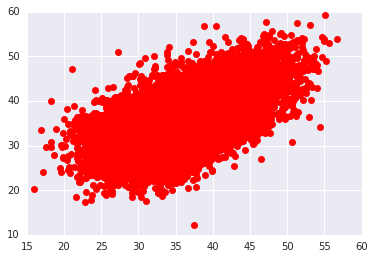

In [171]:
plt.plot(pred_X_titles, pred_X_urls, 'ro')

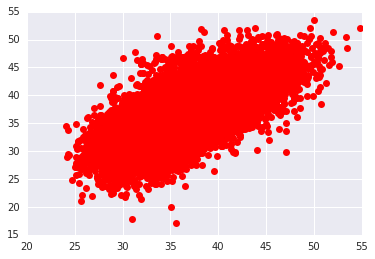

In [172]:
plt.plot(pred_X_nmf_title1, pred_X_nmf_urls1, 'ro')

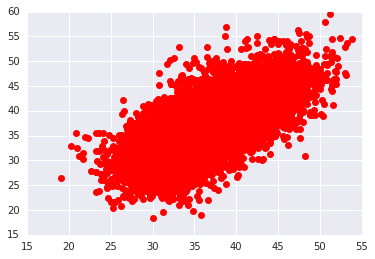

In [173]:
plt.plot(pred_X_nmf_title2, pred_X_nmf_urls2, 'ro')

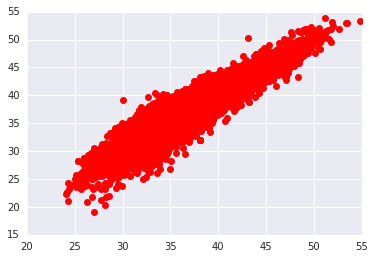

In [176]:
plt.plot(pred_X_nmf_title1, pred_X_nmf_title2, 'ro')

11.7337790362


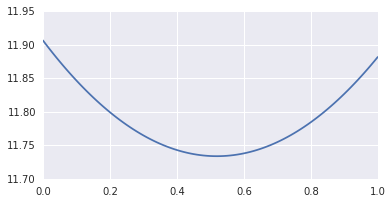

In [119]:
error = []
for w in np.linspace(0, 1, 101):
     error += [rmse(y[ite], pred_X_urls * w + (1-w) * pred_X_titles)]

pd.Series(error, index=np.linspace(0, 1, 101)).plot(figsize=(6,3))
print min(error)

combination on all

In [77]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_urls, y)

pred_X_urls_all = reg.predict(X_urls_test)

CPU times: user 1min 29s, sys: 2min 15s, total: 3min 45s
Wall time: 20.9 s


In [78]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_titles, y)

pred_X_titles_all = reg.predict(X_titles_test)

CPU times: user 4min 57s, sys: 5min 11s, total: 10min 8s
Wall time: 1min 7s


In [79]:
X_urls.shape, X_titles.shape

((118679, 1000), (118679, 2000))

In [80]:
pred_X_urls_all[:10]

array([ 39.71610381,  41.56605595,  41.54794928,  32.61228843,
        39.07584376,  38.2834281 ,  42.48696747,  36.08954451,
        42.25106242,  44.18173812])

In [81]:
pred_X_titles_all[:10]

array([ 37.57136639,  41.88855385,  33.87670624,  34.1181525 ,
        35.53460644,  35.13393273,  45.25657435,  37.4247949 ,
        44.15919005,  44.03959092])

In [82]:
res_pred = 0.5*pred_X_urls_all + 0.5*pred_X_titles_all

In [83]:
res_pred[:10]

array([ 38.6437351 ,  41.7273049 ,  37.71232776,  33.36522047,
        37.3052251 ,  36.70868041,  43.87177091,  36.75716971,
        43.20512623,  44.11066452])

## Blenging с помощью heamy
pip install heamy

https://github.com/rushter/heamy

In [138]:
from sklearn import pipeline, preprocessing, feature_extraction

In [216]:
#%%time

dataset_titles = Dataset(X_titles[itrain, :], y[itrain], X_titles[ite, :])
dataset_urls = Dataset(X_urls[itrain, :], y[itrain], X_urls[ite, :]) 

dataset_titles_nmf = Dataset(X_nmf_title1[itrain, :], y[itrain], X_nmf_title1[ite, :])
dataset_urls_nmf = Dataset(X_nmf_urls1[itrain, :], y[itrain], X_nmf_urls1[ite, :])

dataset_titles_nmf2 = Dataset(X_nmf_title2[itrain, :], y[itrain], X_nmf_title2[ite, :])
dataset_urls_nmf2 = Dataset(X_nmf_urls2[itrain, :], y[itrain], X_nmf_urls2[ite, :])

# линейная модель на обычных данных
lr1 = Regressor(dataset=dataset_urls, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr1')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr1 = Regressor(dataset=dataset_urls,
                      estimator=tfidf_lr_,
                      name='tfidf_lr1')

lr2 = Regressor(dataset=dataset_titles, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr2')


lr3 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr3')

lr4 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr4')

lr5 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr5')

lr6 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr6')



tfidf_lr2 = Regressor(dataset=dataset_titles,
                     estimator=tfidf_lr_,
                     name='tfidf_lr2')

"""xgb_regr2 = Regressor(dataset=dataset_titles, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 1500, 'max_depth':5, 'learning_rate': 0.03,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr2')"""

# ExtraTrees на NMF
xgb_regr1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr1')

xgb_regr2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr2')

xgb_regr3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr3')

xgb_regr4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr4')



rf1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf1')

rf2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf2')


rf3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf3')

rf4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf4')

# Stack four models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr1, lr2, lr3, lr4, lr5, lr6, tfidf_lr1, tfidf_lr2, rf1, rf2, rf3, rf4, xgb_regr1, xgb_regr2, xgb_regr3, xgb_regr4)
stack_ds_all = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds_all, estimator=LinearRegression)
results = stacker.predict()

In [217]:
print('ok')

ok


In [218]:
print rmse(y[ite], results)

11.6098376789


tune et clf

In [195]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(n_estimators=200, max_depth=None, min_samples_split=1, min_samples_leaf=3, 
                         min_weight_fraction_leaf=0.0,
                         bootstrap=True, oob_score=True, n_jobs=-1, 
                         random_state=42, verbose=1, warm_start=True)


et.fit(X_nmf_title2[itrain, :], y[itrain])
print rmse(y[ite], et.predict(X_nmf_title2[ite, :]))

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.6s finished


11.8946575865
CPU times: user 1h 33min 57s, sys: 2.05 s, total: 1h 33min 59s
Wall time: 4min 14s


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.5s finished


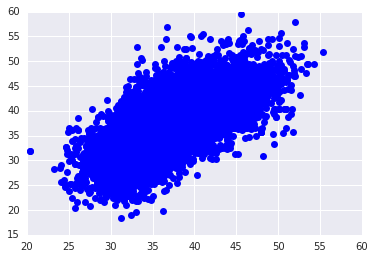

In [200]:
plt.plot(et.predict(X_nmf_title2[ite, :]), pred_X_nmf_urls2, 'bo')

xgb parameter tuning

In [213]:
param = {}
param['max_depth'] = 3
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.01
param['subsample'] = 0.6
param['colsample_bytree'] = 0.9
param['colsample_bylevel'] = 0.7
#param['min_child_weight'] = 1
param['gamma'] = 0.1
#param['reg_alpha'] = 1e-05
#param['scale_pos_weight'] = 1

numround = 1000

In [214]:

X_all_datatrain = xgb.DMatrix(X_nmf_urls2, label = y)

In [215]:
X_all_datatrain = xgb.DMatrix(X_nmf_urls2, label = y)

xgb.cv(param, X_all_datatrain, num_boost_round=5000, nfold=3, metrics="rmse", \
       verbose_eval=10, as_pandas=False, seed=27)

[0]	train-rmse:37.3679+0.0242207	test-rmse:37.3679+0.0492523
[10]	train-rmse:34.1916+0.0228641	test-rmse:34.1921+0.0492532
[20]	train-rmse:31.3558+0.0206975	test-rmse:31.3569+0.0504866
[30]	train-rmse:28.8258+0.0188912	test-rmse:28.8277+0.0515205
[40]	train-rmse:26.5781+0.0174202	test-rmse:26.5807+0.0521531
[50]	train-rmse:24.5859+0.017571	test-rmse:24.5895+0.0513408
[60]	train-rmse:22.8263+0.0173039	test-rmse:22.8306+0.0509461
[70]	train-rmse:21.278+0.0165585	test-rmse:21.2834+0.0510797
[80]	train-rmse:19.9204+0.0167031	test-rmse:19.9267+0.0507652
[90]	train-rmse:18.7367+0.0166239	test-rmse:18.7444+0.0503545
[100]	train-rmse:17.7094+0.0160764	test-rmse:17.7188+0.0504113
[110]	train-rmse:16.8205+0.0160419	test-rmse:16.8312+0.0497623
[120]	train-rmse:16.0562+0.0160472	test-rmse:16.0682+0.049665
[130]	train-rmse:15.401+0.0159492	test-rmse:15.4144+0.0490901
[140]	train-rmse:14.8423+0.0161323	test-rmse:14.8572+0.0483068
[150]	train-rmse:14.3678+0.0160437	test-rmse:14.384+0.0477125
[160]	tr

KeyboardInterrupt: 

In [189]:
%%time
xgb_regr1 = xgb.XGBRegressor(n_estimators=5000, max_depth=3, learning_rate=0.01, subsample=0.6, 
                             colsample_bytree=0.9, colsample_bylevel = 0.7, gamma=0.1, )
xgb_regr1.fit(X_nmf_title1[itrain, :], y[itrain])

pred_xgb1 = xgb_regr1.predict(X_nmf_title1[ite, :])
print rmse(y[ite], pred_xgb1)

11.8325464979
CPU times: user 1h 3min 33s, sys: 2.38 s, total: 1h 3min 35s
Wall time: 2min 43s


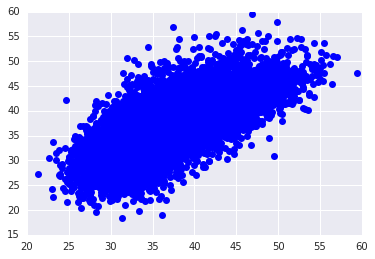

In [190]:
plt.plot(pred_xgb1, pred_X_nmf_urls2, 'bo')

### Обучаем на все

In [219]:
#%%time

dataset_titles = Dataset(X_titles, y, X_titles_test)
dataset_urls = Dataset(X_urls, y, X_urls_test) 

dataset_titles_nmf = Dataset(X_nmf_title1, y, X_nmf_title_test1)
dataset_urls_nmf = Dataset(X_nmf_urls1, y, X_nmf_urls_test1)

dataset_titles_nmf2 = Dataset(X_nmf_title2, y, X_nmf_title_test2)
dataset_urls_nmf2 = Dataset(X_nmf_urls2, y, X_nmf_urls_test2)

# линейная модель на обычных данных
lr1 = Regressor(dataset=dataset_urls, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr1')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr1 = Regressor(dataset=dataset_urls,
                     estimator=tfidf_lr_,
                     name='tfidf_lr1')

lr2 = Regressor(dataset=dataset_titles, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr2')


lr3 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr3')

lr4 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr4')

lr5 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr5')

lr6 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr6')



tfidf_lr2 = Regressor(dataset=dataset_titles,
                     estimator=tfidf_lr_,
                     name='tfidf_lr2')

"""xgb_regr2 = Regressor(dataset=dataset_titles, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 1500, 'max_depth':5, 'learning_rate': 0.03,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr2')"""

# ExtraTrees на NMF
xgb_regr1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr1')

xgb_regr2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr2')

xgb_regr3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr3')

xgb_regr4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr4')



rf1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf1')

rf2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf2')


rf3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf3')

rf4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf4')

# Stack four models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr1, lr2, lr3, lr4, lr5, lr6, tfidf_lr1, tfidf_lr2, rf1, rf2, rf3, rf4, xgb_regr1, xgb_regr2, xgb_regr3, xgb_regr4)
stack_ds_all = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds_all, estimator=LinearRegression)
results = stacker.predict()

In [228]:
stack_ds_all.X_test.to_csv("stack_many_test.csv", index=False)

In [229]:
results

array([ 40.2761439 ,  40.02110021,  37.10676274, ...,  37.76762775,
        37.76762775,  38.36590777])

In [221]:
test_df["age"] = results

In [222]:
test_df.head()

,Id,title,urls,age
0,000000014A02348E701552980349FF01,11-й гектар дом коммунизм на набережная недост...,1000bankov 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv 4pu...,40.276144
1,000000014A10EA183BF8594A0B2AB201,20-летний выглядеть девушка как королева наташ...,autorambler bilettorg dsol-druzhba family.ramb...,40.021100
2,000000014A4FE5C33A929D4C26943601,медийный портал рамблер,photosight photosight photosight photosight ph...,37.106763
3,000000014B7BB9957784A9BC0AC9F401,бесплатно код онлайн срочно статистика или инн...,base.consultant dogovor-obrazets fd mail.rambl...,37.370988
4,000000014C7749F896D82C2B01E8B801,bank privat автокредитование банковский банком...,assessor assessor audit-it base.garant compsam...,30.618663


In [223]:
all_set = test_df[["Id", "age"]]

In [166]:
all_set = all_set.sort_values(by="Id")

In [224]:
all_set.to_csv("stack_6linreg_title_urls_with_nmf_4rf_4xgb.csv", index=False, encoding='utf-8')

In [211]:
all_set = urls_test_df.merge(miss_df, how='outer')[["Id", "age"]]

In [362]:
all_set.head()

,Id,age
0,000000014A02348E701552980349FF01,40.276144
1,000000014A10EA183BF8594A0B2AB201,40.021100
2,000000014A4FE5C33A929D4C26943601,37.106763
3,000000014B7BB9957784A9BC0AC9F401,37.370988
4,000000014C7749F896D82C2B01E8B801,30.618663


In [213]:
all_set.sort_values(by="Id").to_csv("stacking_with_titles_2lr_tfidfLR_2xgb.csv", index=False)